In [1]:
# from Pipeline import WifiPipeline
from MulticlassDCP import WifiMulticlassDCP

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler

# System libraries
import itertools
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Create, process dataframe

In [2]:
start_time = time.time()

In [3]:
w = WifiMulticlassDCP()

In [4]:
df = w.make_dataframe()

# Take out packets from router
df = df[df["DeviceType"]!="router"]
print len(df)

Router     101880
Mini        75782
Dropcam     45912
Kasa        17156
Netcam2      3056
Netcam3      2961
Netcam1      2314
Switch2      2204
Switch1      1963
Switch3      1955
Insight      1738
Switch4      1504
Lifx2         545
Lifx1         495
TpPlug        366
TpBulb        191
Name: Name, dtype: int64
158142


# Prep dataset

In [5]:
# Wifi: Define which features to use
features_list = [
        # Packet info
        "PacketLength",
        
        # Vendor 
         "Belkin", "Dropcam", "Lifi", "Netgear", "Tp-link",
    
        # 802.11 Data subtype
        "Data", "QoS_Data", "QoS_Null",

        # Associated Packets
        "Assoc_Packets"]

# Define what the response classes are
y_list = ["bulb", "camera", "plug"]

In [6]:
# Prep training set
df_train = df[df['Set']=='train']
print df_train['DeviceType'].value_counts()

plug      83642
camera    51282
bulb        686
Name: DeviceType, dtype: int64


Initial test set distribution:
camera    20117
plug       1870
bulb        545
Name: DeviceType, dtype: int64


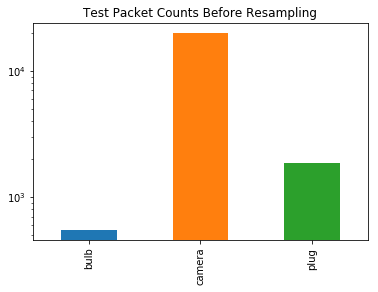

In [7]:
df_test = df[df['Set']=='test']

# Show initial test set imbalance
print "Initial test set distribution:"
print df_test['DeviceType'].value_counts()
df_test['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Before Resampling",logy=True);

In [8]:
# Downsample test set so that there is equal chance that the classifier will choose any given class
rds = RandomUnderSampler(random_state=42)
test_X_downsampled, test_y_downsampled = rds.fit_resample(df_test[features_list], df_test['DeviceType'])

# Show class counts after downsampling
unique, counts = np.unique(test_y_downsampled, return_counts=True)
print np.asarray((unique, counts)).T

[['bulb' 545]
 ['camera' 545]
 ['plug' 545]]


In [9]:
# Recreate df_test 
df_test_downsampled = pd.DataFrame(test_X_downsampled,columns=features_list)
df_test_downsampled['DeviceType'] = test_y_downsampled

# Run multiclass

In [10]:
multiclass_start = time.time()

preds, metrics, cms, feature_importance = w.run_multiclass(df_train, df_test_downsampled, features_list, y_list)

multiclass_end = time.time() - multiclass_start

# Report results

## Report confusion matrices

Confusion matrix, without normalization
[[537   4   4]
 [  0 342 203]
 [  3 102 440]]
Confusion matrix, without normalization
[[545   0   0]
 [  0 194 351]
 [  0 130 415]]
Confusion matrix, without normalization
[[545   0   0]
 [166  44 335]
 [103  15 427]]


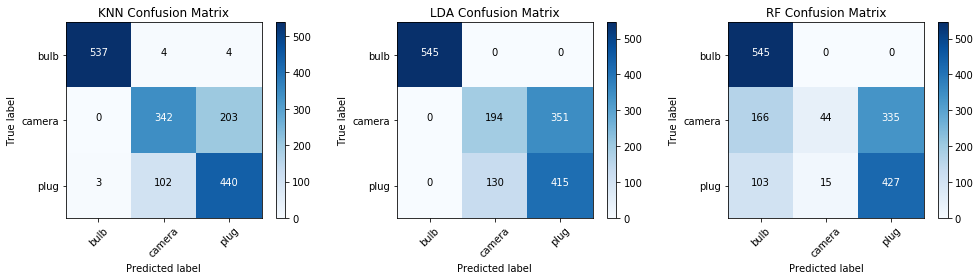

In [11]:
w.plot_all_confusion_matrices(cms, y_list)

## Report metrics

In [12]:
metrics_df = w.report_metrics(metrics, y_list, 'wifi-multiclass_metrics')
display(metrics_df)

,BACC,Matt_Corr,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
knn,0.806728,0.714077,0.994444,0.763393,0.680062,0.985321,0.627523,0.807339
rf,0.621407,0.482981,0.669533,0.745763,0.560367,1.000000,0.080734,0.783486
lda,0.705810,0.574687,1.000000,0.598765,0.541775,1.000000,0.355963,0.761468


## Report feature importance

In [13]:
f_i = w.report_featureimportance(feature_importance, features_list)
display(f_i)

Dropcam         0.78594
Belkin          0.09893
PacketLength    0.07678
Assoc_Packets   0.01845
QoS_Null        0.01272
QoS_Data        0.00259
Data            0.00213
Lifi            0.00198
Tp-link         0.00046
Netgear         0.00000
dtype: float64

# Residuals Analysis

## Use *k* top features only

### Find *k*

In [30]:
fs_start = time.time()

# Find best features using KBest scheme
feature_selection = []
for i in range(0,len(f_i)):
    top_features = list(f_i.index[0:i+1])

    tf_preds, tf_metrics, tf_cms, tf_feature_importance = w.run_multiclass(df_train, df_test_downsampled, top_features, y_list,use_tuned=False)
    tf_metrics_df = w.report_metrics(tf_metrics, y_list, to_csv=False)
    
    ave = np.average(tf_metrics_df['BACC'])
    feature_selection.append(ave)
    
fs_end = time.time() - fs_start

In [31]:
k = feature_selection.index(max(feature_selection))
print 'Best BACC',max(feature_selection),":", k+1, "features"

Best BACC 0.7135575942915393 : 8 features


### Run multiclass with top *k* features

In [32]:
# Run multiclass with top k features
tf_preds, tf_metrics, tf_cms, tf_feature_importance = w.run_multiclass(df_train, df_test_downsampled, list(f_i.index[0:k+1]), y_list,use_tuned=False)

In [33]:
tf_metrics_df = w.report_metrics(tf_metrics, y_list, 'wifi-topfeatures_metrics')
display(tf_metrics_df)

,BACC,Matt_Corr,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
knn,0.62630,0.48372,0.99444,0.30719,0.46709,0.98532,0.08624,0.80734
rf,0.80856,0.73651,0.66953,0.95890,0.93640,1.00000,0.64220,0.78349
lda,0.70581,0.57469,1.00000,0.59877,0.54178,1.00000,0.35596,0.76147


### Plot confusion matrices

Confusion matrix, without normalization
[[537   4   4]
 [  0  47 498]
 [  3 102 440]]
Confusion matrix, without normalization
[[545   0   0]
 [  0 194 351]
 [  0 130 415]]
Confusion matrix, without normalization
[[545   0   0]
 [166 350  29]
 [103  15 427]]


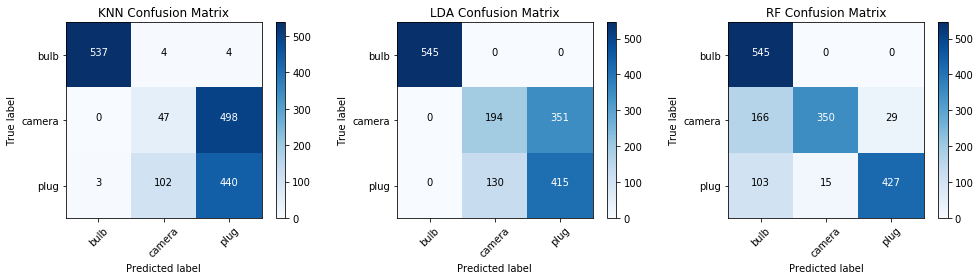

In [34]:
w.plot_all_confusion_matrices(tf_cms, y_list)

### Report feature importance of *k* best

In [35]:
w.report_featureimportance(tf_feature_importance, f_i.index[0:k+1])

Belkin          0.45579
Assoc_Packets   0.36083
Dropcam         0.09774
PacketLength    0.03345
Data            0.02940
QoS_Null        0.01609
QoS_Data        0.00384
Lifi            0.00285
dtype: float64

## Remove vendor features

In [36]:
# Remove vendors features
nv_features = ['PacketLength', 'Tp-link', 'Data', 'QoS_Data', 'QoS_Null', 'Assoc_Packets']

In [37]:
nv_start = time.time()

# Run multiclass with top k features
nv_preds, nv_metrics, nv_cms, nv_feature_importance = w.run_multiclass(df_train, df_test_downsampled, nv_features, y_list,use_tuned=False)

nv_end = time.time() - nv_start

In [38]:
nv_metrics_df = w.report_metrics(nv_metrics, y_list, 'wifi-novendor_metrics')
display(nv_metrics_df)

,BACC,Matt_Corr,Precision_Bulb,Precision_Camera,Precision_Plug,Recall_Bulb,Recall_Camera,Recall_Plug
knn,0.78899,0.68661,0.99413,0.71698,0.68006,0.93211,0.62752,0.80734
rf,0.59572,0.42171,0.91257,0.22549,0.48413,0.91927,0.08440,0.78349
lda,0.27156,-0.09269,0.00000,0.05503,0.77570,0.00000,0.05321,0.76147


Confusion matrix, without normalization
[[508  33   4]
 [  0 342 203]
 [  3 102 440]]
Confusion matrix, without normalization
[[  0 471  74]
 [470  29  46]
 [103  27 415]]
Confusion matrix, without normalization
[[501  43   1]
 [ 45  46 454]
 [  3 115 427]]


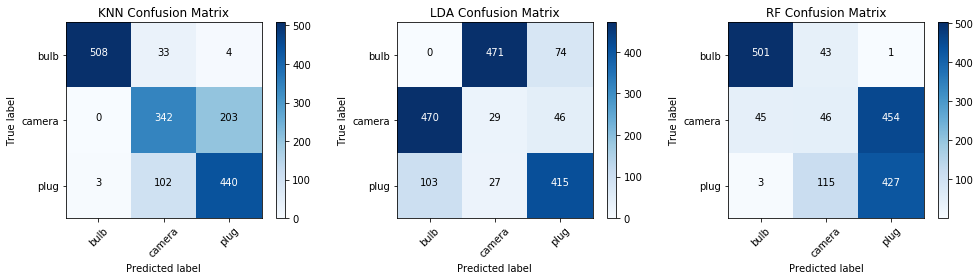

In [39]:
w.plot_all_confusion_matrices(nv_cms, y_list)

In [40]:
w.report_featureimportance(nv_feature_importance, nv_features)

Assoc_Packets   0.92705
PacketLength    0.03658
QoS_Null        0.01230
Data            0.01108
QoS_Data        0.01063
Tp-link         0.00236
dtype: float64

## Error analysis

**Error 1**: 

In [41]:
print multiclass_end
print fs_end
print nv_end
print time.time() - start_time

66.7034990788
396.101758957
33.9089641571
2586.4478929
